In [1]:
# from argopy import DataFetcher as ArgoDataFetcher
import importlib, os, gc, sys

import SXBQ as sx

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import matplotlib.dates as mdates
import math

from datetime import datetime

from matplotlib.gridspec import GridSpec

import glidertools as gt
import matplotlib.colors as colors
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import data:
sigmaaxis=np.arange(20,28,0.005)
yaxis=np.arange(0,1000,1)

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

In [3]:
## load data

#gridded
ds_sections_02=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/gridded_SG502_noML_fixedpgw.nc')
ds_sections_79=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/gridded_SG579_noML_fixedpgw.nc')
ds_sections_10=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/gridded_SG510_noML_fixedpgw.nc')
ds_sections_57=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/gridded_SEA057_noML_fixedpgw_adcp_detided.nc')


#timesereis
ds= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/SEA057.nc')
ds_02= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG502.nc')
ds_10= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG510.nc')
ds_79= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG579.nc')
ds_57_adcp=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/SEA057_adcp.nc')

In [1]:
## Figure S1

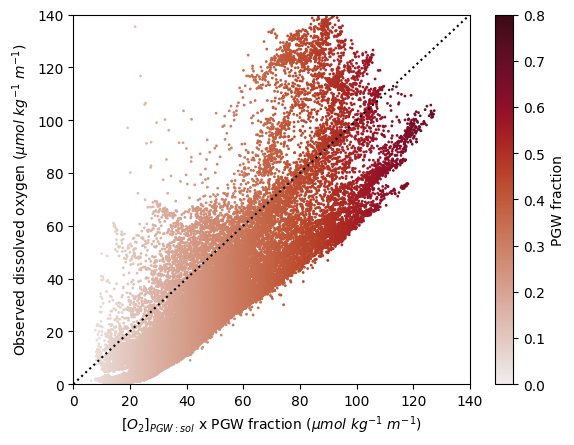

In [13]:
o2_sol= gsw.O2sol(gsw.SA_from_SP( 40.85, 0, 58,24),gsw.CT_from_t(gsw.SA_from_SP( 40.85, 0, 58,24), 29.8,0), 0, 56, 26.5) 

dpt=160
N=100
plt.scatter(ds.pgw_frac[::N]*(ds.pressure[::N]>dpt)*o2_sol,ds.oxygen_concentration[::N]*(ds.pressure[::N]>dpt), c=ds.pgw_frac[::N]*(ds.pressure[::N]>dpt), cmap=cmo.amp, s=1, vmin=0, vmax=0.8,label='2021-22')

plt.plot([0,140], [0,140], c='k', ls='dotted')
plt.xlabel('$[O_2]_{PGW:sol}$ x PGW fraction ($\mu mol$ $kg^{-1}$ $m^{-1}$)')
plt.ylabel('Observed dissolved oxygen ($\mu mol$ $kg^{-1}$ $m^{-1}$)')
cb=plt.colorbar()
cb.set_label('PGW fraction')
plt.ylim([0,140])
plt.xlim([0,140])

plt.savefig('Figure_supl_1.png', dpi=600)

## SSH - Figre 4 and S4


In [14]:
## datasets altimery
df_14= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1693900584098.nc')
df_1= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/c3s_obs-sl_glo_phy-ssh_my_twosat-l4-duacs-0.25deg_P1D_1690546044610.nc')
df_2= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/dataset-duacs-nrt-global-merged-allsat-phy-l4_1690537288253.nc')
df_23= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/dataset-duacs-nrt-global-merged-allsat-phy-l4_1693900327657.nc')

df=xr.merge([df_14, df_1, df_2, df_23])
df_int=df.interp(latitude=np.arange(df.latitude.min().item(),df.latitude.max().item(),0.02), longitude=np.arange(df.longitude.min().item(),df.longitude.max().item(),0.02))

bathy = xr.open_dataset('/home/jupyter-estelfont/datasets/bathymetry/gebco_2021_n27.034836007723463_s22.13122092221953_w56.064565535880384_e61.45197185201736.nc')

## Figure 4

In [132]:
mth=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

def axis_lol(ax, col15, col21):
    ax.contourf(bathy.lon,bathy.lat, bathy.elevation,  levels=[0,3000], alpha=0.5, colors='lightgray', zorder=-10)
    ax.plot([58.63,59.03],[23.65, 24.28], lw=3, c=col15, linestyle='dashed', label=r'2015-16', zorder=2)
    ax.plot([57.4931,57.9126],[24.0397,24.6507],lw=3,c=col21, label='2021-22', zorder=2)    
    ax.set_ylim(22.5,26)
    ax.set_xlim(56.25, 60.5)

df_int=df_int.sel(time=slice('2015', '2022'))
df=df.sel(time=slice('2015', '2022'))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmapi = plt.get_cmap('cmo.tarn')
new_cmap = truncate_colormap(cmapi, 0.5, 0.9)
new_cmap

cmapi = plt.get_cmap('cmo.ice', 6)
c_glid=[cmapi(1),cmapi(2),cmapi(3),cmapi(4)] #glider colors

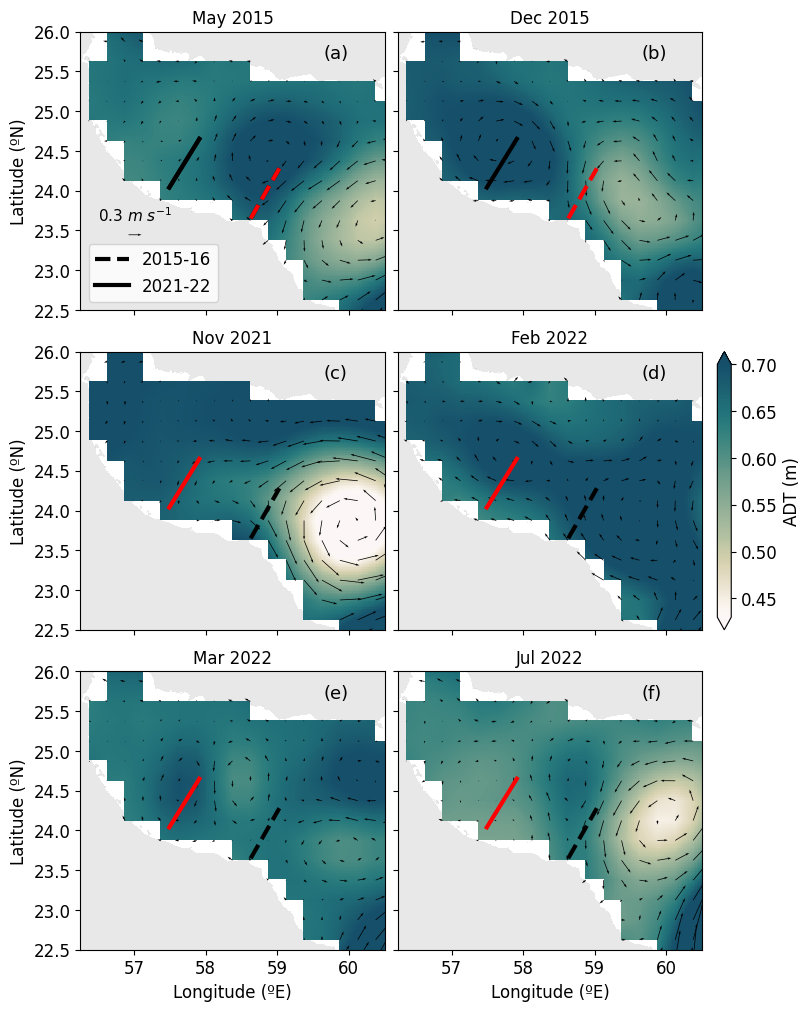

In [78]:
## fnts=12
minn=1-.2
maxx=0.905
SC=7
alp=0

plt.figure(figsize=(8,10), constrained_layout=True)
yr='2015'
loli=df_int.sel(time=slice('2015', '2015-12-31')).groupby('time.month')
loli2=df.sel(time=slice('2015', '2015-12-31')).groupby('time.month')

plt.subplot(321)
i=4
plt.title(mth[i] + ' ' +yr, fontsize=fnts)
cb=plt.pcolormesh(df_int.longitude, df_int.latitude, loli[i+1].mean('time').adt, vmin=0.43, vmax=0.7, zorder=0, cmap=new_cmap)
# plt.colorbar(cb)
k=plt.quiver(df.longitude, df.latitude, loli2[i+1].mean('time').ugos, loli2[i+1].mean('time').vgos, scale=SC, zorder=2)
plt.quiverkey(k, 0.18, 0.27, 0.3, '0.3 $m$ $s^{-1}$', fontproperties={'size':fnts-1}, zorder=100)
ax = plt.gca()
ax.plot([58.63,59.03],[23.65, 24.28], lw=3, c='k', linestyle='dashed', label=r'2015-16', zorder=2)
ax.plot([57.4931,57.9126],[24.0397,24.6507],lw=3,c='k', label='2021-22', zorder=2)
plt.legend(loc=3, fontsize=fnts)
# plt.scatter(60.2, 25.75, s=200, c=c_glid[0], zorder=500)
axis_lol(ax, 'r', 'k') 

ax.set_ylabel('Latitude (ºN)', fontsize=fnts)
ax.set_xticklabels([])

t=ax.text(x=minn,y=maxx,s="(" + letters[0] + ')',size=fnts+1,transform=ax.transAxes, zorder=100)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.gca().tick_params(axis='both', labelsize=fnts)


plt.subplot(322)
i=11
yr='2015'
plt.title(mth[i] + ' ' +yr, fontsize=fnts)
cb=plt.pcolormesh(df_int.longitude, df_int.latitude, loli[i+1].mean('time').adt, vmin=0.43, vmax=0.7, zorder=0, cmap=new_cmap)
# plt.colorbar(cb)
k=plt.quiver(df.longitude, df.latitude, loli2[i+1].mean('time').ugos, loli2[i+1].mean('time').vgos, scale=SC, zorder=2)
# plt.quiverkey(k, 0.18, 0.25, 0.5, '0.5 $m \cdot s^{-1}$', fontproperties={'size':fnts}, zorder=100)
ax = plt.gca()
axis_lol(ax, 'r', 'k') 
ax.set_yticklabels([])
ax.set_xticklabels([])

t=ax.text(x=minn,y=maxx,s="(" + letters[1] + ')',size=fnts+1,transform=ax.transAxes, zorder=100)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
plt.gca().tick_params(axis='both', labelsize=fnts)
# plt.scatter(60.2, 25.75, s=200, c=c_glid[2], zorder=500)


plt.subplot(323)
i=10
yr='2021'
loli=df_int.sel(time=slice('2021', '2021-12-31')).groupby('time.month')
loli2=df.sel(time=slice('2021', '2021-12-31')).groupby('time.month')

plt.title(mth[i] + ' ' +yr, fontsize=fnts)
cb=plt.pcolormesh(df_int.longitude, df_int.latitude, loli[i+1].mean('time').adt, vmin=0.43, vmax=0.7, zorder=0, cmap=new_cmap)
# plt.colorbar(cb)
k=plt.quiver(df.longitude, df.latitude, loli2[i+1].mean('time').ugos, loli2[i+1].mean('time').vgos, scale=SC, zorder=2)
# plt.quiverkey(k, 0.18, 0.25, 0.5, '0.5 $m \cdot s^{-1}$', fontproperties={'size':fnts}, zorder=100)
ax = plt.gca()
axis_lol(ax, 'k', 'r') 
ax.set_ylabel('Latitude (ºN)', fontsize=fnts)
ax.set_xticklabels([])

t=ax.text(x=minn,y=maxx,s="(" + letters[2] + ')',size=fnts+1,transform=ax.transAxes, zorder=100)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
plt.gca().tick_params(axis='both', labelsize=fnts)
# plt.scatter(60.2, 25.75, s=200, c=c_glid[3], zorder=500)


plt.subplot(324)
i=1
yr='2022'
loli=df_int.sel(time=slice('2022', '2022-12-31')).groupby('time.month')
loli2=df.sel(time=slice('2022', '2022-12-31')).groupby('time.month')

plt.title(mth[i] + ' ' +yr, fontsize=fnts)
cb=plt.pcolormesh(df_int.longitude, df_int.latitude, loli[i+1].mean('time').adt, vmin=0.43, vmax=0.7, zorder=0, cmap=new_cmap)
cb=plt.colorbar(cb, extend='both')
cvv=cb.set_label('ADT (m)', fontsize=fnts)
cb.ax.tick_params(labelsize=fnts)

k=plt.quiver(df.longitude, df.latitude, loli2[i+1].mean('time').ugos, loli2[i+1].mean('time').vgos, scale=SC, zorder=2)
# plt.quiverkey(k, 0.18, 0.25, 0.5, '0.5 $m \cdot s^{-1}$', fontproperties={'size':fnts}, zorder=100)
ax = plt.gca()
axis_lol(ax, 'k', 'r') 
ax.set_yticklabels([])
ax.set_xticklabels([])
t=ax.text(x=minn,y=maxx,s="(" + letters[3] + ')',size=fnts+1,transform=ax.transAxes, zorder=100)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
plt.gca().tick_params(axis='both', labelsize=fnts)
# plt.scatter(60.2, 25.75, s=200, c=c_glid[3], zorder=500)


plt.subplot(325)
i=2

plt.title(mth[i] + ' ' +yr, fontsize=fnts)
cb=plt.pcolormesh(df_int.longitude, df_int.latitude, loli[i+1].mean('time').adt, vmin=0.43, vmax=0.7, zorder=0, cmap=new_cmap)
# plt.colorbar(cb)
k=plt.quiver(df.longitude, df.latitude, loli2[i+1].mean('time').ugos, loli2[i+1].mean('time').vgos, scale=SC, zorder=2)
# plt.quiverkey(k, 0.18, 0.25, 0.5, '0.5 $m \cdot s^{-1}$', fontproperties={'size':fnts}, zorder=100)
ax = plt.gca()
axis_lol(ax, 'k', 'r') 
ax.set_xlabel('Longitude (ºE)', fontsize=fnts)
ax.set_ylabel('Latitude (ºN)', fontsize=fnts)
t=ax.text(x=minn,y=maxx,s="(" + letters[4] + ')',size=fnts+1,transform=ax.transAxes, zorder=100)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.gca().tick_params(axis='both', labelsize=fnts)
# plt.scatter(60.2, 25.75, s=200, c=c_glid[3], zorder=500)

    
plt.subplot(326)
i=6
plt.title(mth[i] + ' ' +yr, fontsize=fnts)
cb=plt.pcolormesh(df_int.longitude, df_int.latitude, loli[i+1].mean('time').adt, vmin=0.43, vmax=0.7, zorder=0, cmap=new_cmap)
k=plt.quiver(df.longitude, df.latitude, loli2[i+1].mean('time').ugos, loli2[i+1].mean('time').vgos, scale=SC, zorder=2)
# plt.quiverkey(k, 0.18, 0.25, 0.5, '0.5 $m \cdot s^{-1}$', fontproperties={'size':fnts}, zorder=100)
ax = plt.gca()
axis_lol(ax, 'k', 'r') 
ax.set_xlabel('Longitude (ºE)', fontsize=fnts)
ax.set_yticklabels([])
t=ax.text(x=minn,y=maxx,s="(" + letters[5] + ')',size=fnts+1,transform=ax.transAxes, zorder=100)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.gca().tick_params(axis='both', labelsize=fnts)
# plt.scatter(60.2, 25.75, s=200, c=c_glid[3], zorder=500)
plt.savefig('Figure_4.png', dpi=600)


## Animation S4

In [ ]:
## glider datasets

ds4=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/SEA057.nc')
ds3=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG510.nc')
ds2=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG502.nc')
ds1=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG579.nc')

get_dates_glid1=pd.DataFrame(ds1.time.values.astype('datetime64[D]')).drop_duplicates().dropna()[0].to_numpy()
get_dates_glid2=pd.DataFrame(ds2.time.values.astype('datetime64[D]')).drop_duplicates().dropna()[0].to_numpy()
get_dates_glid3=pd.DataFrame(ds3.time.values.astype('datetime64[D]')).drop_duplicates().dropna()[0].to_numpy()
get_dates_glid4=pd.DataFrame(ds4.time.values.astype('datetime64[D]')).drop_duplicates().dropna()[0].to_numpy()

list_days_glidinwater=np.concatenate([get_dates_glid1, get_dates_glid2, get_dates_glid3, get_dates_glid4])

interception_dates_1=np.in1d(df_int.time.values, get_dates_glid1)
interception_dates_2=np.in1d(df_int.time.values, get_dates_glid2)
interception_dates_3=np.in1d(df_int.time.values, get_dates_glid3)
interception_dates_4=np.in1d(df_int.time.values, get_dates_glid4)

# grid in time
def grid_t(ds, var, taxis, yaxis):
    var_g, x, y=  sx.grid2d(
        ds.time.values,
        ds.pressure.values, 
        ds[var].values, 
        xi=taxis, yi=yaxis, fn='mean')
    return var_g
taxis1= np.arange(np.datetime64('2015-01-01'), np.datetime64('2017-01-01'), np.timedelta64(1, "D"))
taxis2= np.arange(np.datetime64('2021-01-01'), np.datetime64('2023-01-01'), np.timedelta64(1, "D"))
taxis=np.concatenate([taxis1, taxis2])

yaxis=np.arange(0,1000,500)
def grid_lat_lon(df):
    lat_ = grid_t(df, 'latitude',taxis,  yaxis)
    lon_=grid_t(df, 'longitude',taxis,  yaxis)
    return lat_[0], lon_[0]

lat15, lon15 = grid_lat_lon(ds1)
lat02, lon02 = grid_lat_lon(ds2)
lat10, lon10 = grid_lat_lon(ds3)
lat57, lon57 = grid_lat_lon(ds4)


# animation packages and functions!
# -- install Pillow
from PIL import Image
import os
import imageio

def resize_images(images, width, height):
    resized_images = []
    for image in images:
        resized_image = image.resize((width, height), Image.ANTIALIAS)
        resized_images.append(resized_image)
    return resized_images

def create_animation(png_folder, output_path, duration=100):
    # Get a list of PNG files in the folder along with their creation time
    png_files_with_time = [(f, os.path.getctime(os.path.join(png_folder, f))) for f in os.listdir(png_folder) if f.endswith(".png")]

    # Sort the files based on their creation time
    png_files_with_time.sort(key=lambda x: x[1])

    # Get only the file names from the sorted list
    png_files_sorted = [f[0] for f in png_files_with_time]

    # Create an animation sequence
    images = []
    for png_file in tqdm(png_files_sorted[:]):
        
        image_path = os.path.join(png_folder, png_file)
        image = Image.open(image_path)
        images.append(image)

#     # Resize images to match the dimensions of the first image
#     width, height = images[0].size
#     images = resize_images(images, 1200, 900)

    # Save the animation as a GIF
    output_path_with_extension = os.path.splitext(output_path)[0] + ".gif"
    imageio.mimsave(output_path_with_extension, images, duration=duration/1000)

In [212]:
x_txt, ytxt=60, 25.75
x_scat, yscat=59.5, 25.75
for N in tqdm(range(len(df_int.time[:]))):
    plt.figure(figsize=(7,5))

    ax=plt.axes()
    
    ax.set_title(pd.to_datetime(df_int.time.values[N]).strftime("%d %b %Y") , fontsize=12)
    cb=plt.pcolormesh(df_int.longitude, df_int.latitude, df_int.isel(time=N).adt, vmin=0.43, vmax=0.7, zorder=0, cmap=new_cmap)
    cb=plt.colorbar(cb, extend='both')
    cvv=cb.set_label('ADT (m)', fontsize=12)
    cb.ax.tick_params(labelsize=12)
    k=plt.quiver(df.longitude, df.latitude, df.isel(time=N).ugos, df.isel(time=N).vgos, scale=SC, zorder=2)
    plt.quiverkey(k, 0.15, 0.1, 0.3, '0.3 $m \cdot s^{-1}$', fontproperties={'size':12}, zorder=100)
    
    axis_lol(ax, 'k', 'k') 
    if interception_dates_1[N]==True:
        ax.scatter(x_scat, yscat, s=200, c=c_glid[0], zorder=100)
        ax.text(x_txt, ytxt, s='SG579', verticalalignment='center', horizontalalignment='center', fontsize=12, zorder=500)
        loni, lati=lon15, lat15
        ax.scatter(loni[N-4], lati[N-4], s=20, alpha=0.2,c='r', zorder=100)
        ax.scatter(loni[N-3], lati[N-3], s=20, alpha=0.4,c='r', zorder=101)
        ax.scatter(loni[N-2], lati[N-2], s=20,alpha=0.6, c='r', zorder=102)
        ax.scatter(loni[N-1], lati[N-1], s=20,alpha=0.8, c='r', zorder=103)
        ax.scatter(loni[N], lati[N], s=20, c='r', zorder=104)
    elif interception_dates_2[N]==True:
        # axis_lol(ax, 'r', 'k') 
        ax.scatter(x_scat, yscat, s=200, c=c_glid[1], zorder=100)
        ax.text(x_txt, ytxt, s='SG502', verticalalignment='center', horizontalalignment='center', fontsize=12, zorder=500)
        loni, lati=lon02, lat02
        ax.scatter(loni[N-4], lati[N-4], s=20, alpha=0.2,c='r', zorder=100)
        ax.scatter(loni[N-3], lati[N-3], s=20, alpha=0.4,c='r', zorder=101)
        ax.scatter(loni[N-2], lati[N-2], s=20,alpha=0.6, c='r', zorder=102)
        ax.scatter(loni[N-1], lati[N-1], s=20,alpha=0.8, c='r', zorder=103)
        ax.scatter(loni[N], lati[N], s=20, c='r', zorder=104)
    elif interception_dates_3[N]==True:
        # axis_lol(ax, 'k', 'r') 
        ax.scatter(x_scat, yscat, s=200, c=c_glid[2], zorder=100)
        ax.text(x_txt, ytxt, s='SG510', verticalalignment='center', horizontalalignment='center', fontsize=12, zorder=500)
        loni, lati=lon10, lat10
        ax.scatter(loni[N-4], lati[N-4], s=20, alpha=0.2,c='r', zorder=100)
        ax.scatter(loni[N-3], lati[N-3], s=20, alpha=0.4,c='r', zorder=101)
        ax.scatter(loni[N-2], lati[N-2], s=20,alpha=0.6, c='r', zorder=102)
        ax.scatter(loni[N-1], lati[N-1], s=20,alpha=0.8, c='r', zorder=103)
        ax.scatter(loni[N], lati[N], s=20, c='r', zorder=104)
    elif interception_dates_4[N]==True:
        # axis_lol(ax, 'k', 'r') 
        ax.scatter(x_scat, yscat, s=200, c=c_glid[3], zorder=100)
        ax.text(x_txt, ytxt, s='SEA057', verticalalignment='center', horizontalalignment='center', fontsize=12, zorder=500)
        loni, lati=lon57, lat57
        ax.scatter(loni[N-4], lati[N-4], s=20, alpha=0.2,c='r', zorder=100)
        ax.scatter(loni[N-3], lati[N-3], s=20, alpha=0.4,c='r', zorder=101)
        ax.scatter(loni[N-2], lati[N-2], s=20,alpha=0.6, c='r', zorder=102)
        ax.scatter(loni[N-1], lati[N-1], s=20,alpha=0.8, c='r', zorder=103)
        ax.scatter(loni[N], lati[N], s=20, c='r', zorder=104)
    else:
        ax.scatter(x_scat, yscat, s=200, c='grey', zorder=100)
    
    plt.xlabel('Longitude (ºE)', fontsize=12)
    plt.ylabel('Latitude (ºN)', fontsize=12)
    plt.gca().tick_params(axis='both', labelsize=12)
    plt.margins(0.1)  # You can experiment with the margin value

    plt.savefig('/home/jupyter-estelfont/PGW_paper/figures/daily_adt/ADT_'+str(N)+'.png')
    plt.close()

  0%|          | 0/1461 [00:00<?, ?it/s]

In [214]:
folder_with_png_files='/home/jupyter-estelfont/PGW_paper/figures/daily_adt/'
output_animation='/home/jupyter-estelfont/PGW_paper/figures/ADT_daily_2015-16-21-22_GoO.gif'

create_animation(folder_with_png_files, output_animation, duration=200)

  0%|          | 0/1461 [00:00<?, ?it/s]